# Trained Model - `python-awips` Visualization
In this notebook, we take our trained model and demonstrate a pipeline that takes satellite data from the Unidata EDEX server and attempts to predict tropical cyclones. 

We start this process by creating an EDEX server request ([inspired by this tutorial](http://unidata.github.io/python-awips/examples/generated/GOES_Geostationary_Lightning_Mapper.html)) for moisture vapor data (ABI channel 9) from the GOES-16 satellite:

In [1]:
# import stuff
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from matplotlib import cm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import datetime
from PIL import Image
from PIL import ImageOps
import tensorflow as tf
import io

# magic stuff
%matplotlib inline

In [2]:
# setup EDEX data request
edexServer = "edex-cloud.unidata.ucar.edu"
datatype = "satellite"  # per http://unidata.github.io/python-awips/datatypes.html
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest(datatype)

# Show available sources/sectors/parameters
sources = DataAccessLayer.getIdentifierValues(request, "creatingEntity")
print("available sources:")
print(list(sources))
print("")
availableSectors = DataAccessLayer.getAvailableLocationNames(request)
print("available sectors:")
print(list(availableSectors))
print("")
availableParms = DataAccessLayer.getAvailableParameters(request)
availableParms.sort()
print("available parameters:")
print(list(availableParms))

available sources:
['GOES-16', 'GOES-17', 'UNIWISC', 'NEXRCOMP']

available sectors:
['EMESO-2', 'Antarctic', 'GOES-East', 'WMESO-2', 'EFD', 'WMESO-1', 'WFD', 'HIREGI', 'WCONUS', 'Arctic', 'AKREGI', 'PRREGI', 'NEXRCOMP', 'EMESO-1', 'ECONUS']

available parameters:
['ACTP', 'ADP', 'AOD', 'CAPE', 'CH-01-0.47um', 'CH-02-0.64um', 'CH-03-0.87um', 'CH-04-1.38um', 'CH-05-1.61um', 'CH-06-2.25um', 'CH-07-3.90um', 'CH-08-6.19um', 'CH-09-6.95um', 'CH-10-7.34um', 'CH-11-8.50um', 'CH-12-9.61um', 'CH-13-10.35um', 'CH-14-11.20um', 'CH-15-12.30um', 'CH-16-13.30um', 'CSM', 'CTH', 'CTT', 'DHR', 'DVL', 'EET', 'FDC Area', 'FDC Power', 'FDC Temp', 'Fog_Depth', 'HHC', 'IFR_Fog_Prob', 'Imager 11 micron IR', 'Imager 12 micron IR', 'Imager 13 micron IR', 'Imager 3.5-4.0 micron IR (Fog)', 'Imager 6.7-6.5 micron IR (WV)', 'Imager Visible', 'KI', 'LI', 'LIFR_Fog_Prob', 'LST', 'MVFR_Fog_Prob', 'N1P', 'NTP', 'RRQPE', 'SI', 'SST', 'TPW', 'TT', 'VMP-0.00hPa', 'VMP-0.02hPa', 'VMP-0.04hPa', 'VMP-0.08hPa', 'VMP-0.14hPa'

Now that we've requested the data sources/sectors/params available from the EDEX server, lets specify exactly what we are looking for - GOES-16 Full Disk (EFD) CH-09-6.95um data:

In [3]:
# modify our request to be more precise
request.addIdentifier("creatingEntity", "GOES-16")
request.setLocationNames("EFD")
request.setParameters("CH-09-6.95um")

# verify our request query is what we want
sources = DataAccessLayer.getIdentifierValues(request, "creatingEntity")
print("available sources:")
print(list(sources))
print("")
availableSectors = DataAccessLayer.getAvailableLocationNames(request)
print("available sectors:")
print(list(availableSectors))
print("")
availableParms = DataAccessLayer.getAvailableParameters(request)
availableParms.sort()
print("available parameters:")
print(list(availableParms))

available sources:
['GOES-16']

available sectors:
['EFD']

available parameters:
['CH-09-6.95um']


In [4]:
# make the request
times = DataAccessLayer.getAvailableTimes(request)
response = DataAccessLayer.getGridData(request, [times[-1]])
grid = response[0]

In [5]:
# the response returns a 2 item tuple which has an array of lons/lats (http://unidata.github.io/python-awips/api/PyGridData.html)
lons, lats = grid.getLatLonCoords()
data = grid.getRawData()
data = np.where(data == 0.0, np.nan, data)
# times[-1] is just a single time so the request only returns one grid object.
# if times[...] was a list then we would use a list:

# mv_points = []
# for data in response:
#     mv_points.append(data.getLatLonCoords())

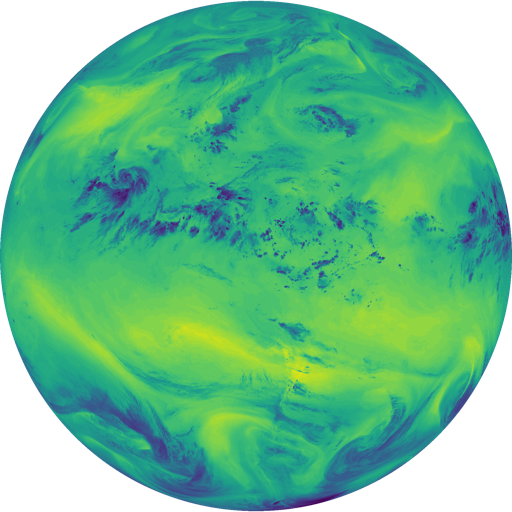

In [6]:
# I did a bad job with the whole take netcdf values and make into an RGB image and now have to deal with that
# ^ to reiterate, this was dumb dont do that again

# start by normalizing the data values in [0,1]
def normalize(data):
    data_min, data_max = (np.nanmin(data), np.nanmax(data))
    norm_arr = lambda x: (x-data_min)/(data_max-data_min)
    return norm_arr(data)
norm_data = normalize(data)

# next map to colors using viridis
viridis = cm.get_cmap('viridis', 50)  # the integer is granularity of color map
cmap_f = lambda x: viridis(x)
cdata = cmap_f(norm_data)

# then convert into image for resizing
img = Image.fromarray((cdata*255).astype(np.uint8))
img = img.resize((512,512))

# then back to array for putting into model
img_arr = np.array(img)[:,:, :3]
img

In [7]:
# load in tensorflow model and evaluate
trained_model = tf.keras.models.load_model('models/cyclone_classifier_trained')
prediction = trained_model.predict(np.expand_dims(img_arr, axis=0))

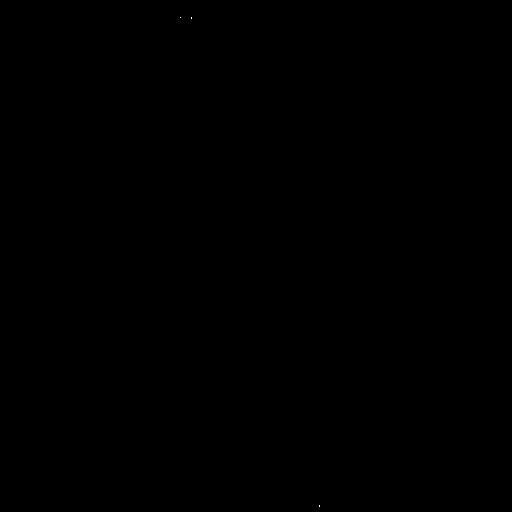

In [8]:
# prediction is a batch with probabilities so we can use argmax
pred_mask = np.argmax(prediction[0], axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)
img = ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))
img